# find grounding line

`DATA/code/tide_gnss_crosses_resample.py` writes the data I plot here

I will try 
1. find the best size buffer and resolution to find the grounding line
2. plot the grounding line

buffer = distance between points deemed 'together' in finding tide changes
resolution = downscaaling of gnss line

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from numpy import linalg as LA
from functools import reduce
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal

from shapely.geometry import Point
from shapely.geometry import MultiPoint
import fiona


In [2]:
paths = glob.glob('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides*.pkl')
paths.sort()
paths

['/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample20mcluster.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_10mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_20mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_30mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_40mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_50mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_50mbuffer_timediff.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_60mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_8mbuffer.pkl',
 '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_1msample_1mbuffer.pkl',
 '/Users/home/

## Plot different resolution and buffers

In [3]:
def plot_tides(i,paths):
    df = pd.read_pickle(paths[i])
    plt.figure(figsize=(15,7))
    plt.plot(df.Latitude,df.tide,'x')
    plt.grid()
    plt.xlabel('latitude')
    plt.ylabel('change in elevation')
    plt.title(os.path.splitext(os.path.split(paths[i])[1])[0])

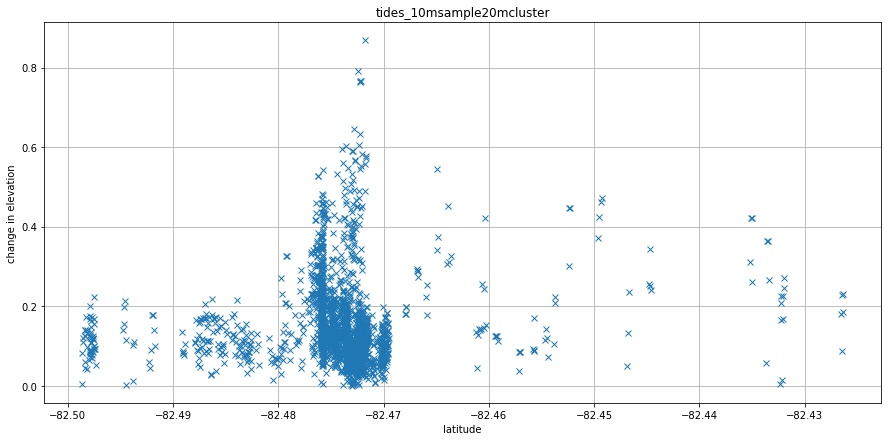

In [4]:
plot_tides(0,paths)

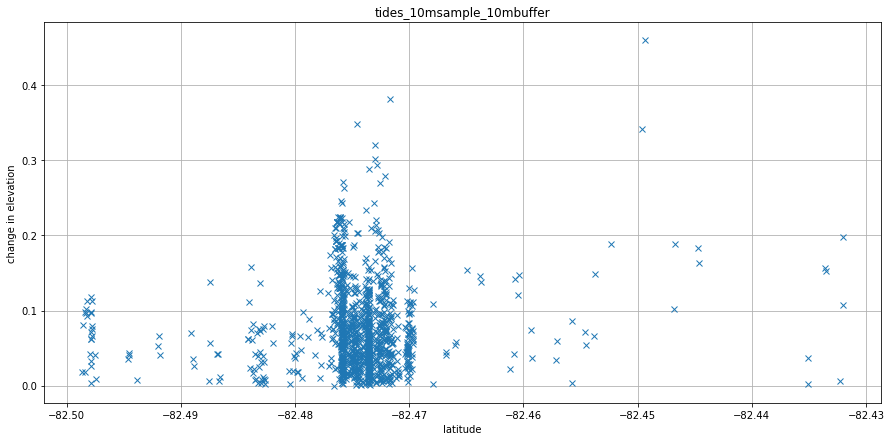

In [5]:
plot_tides(1,paths)

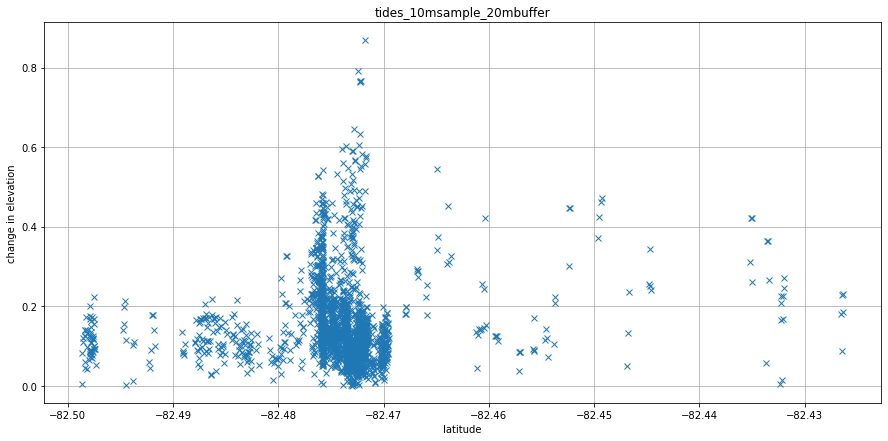

In [6]:
plot_tides(2,paths)

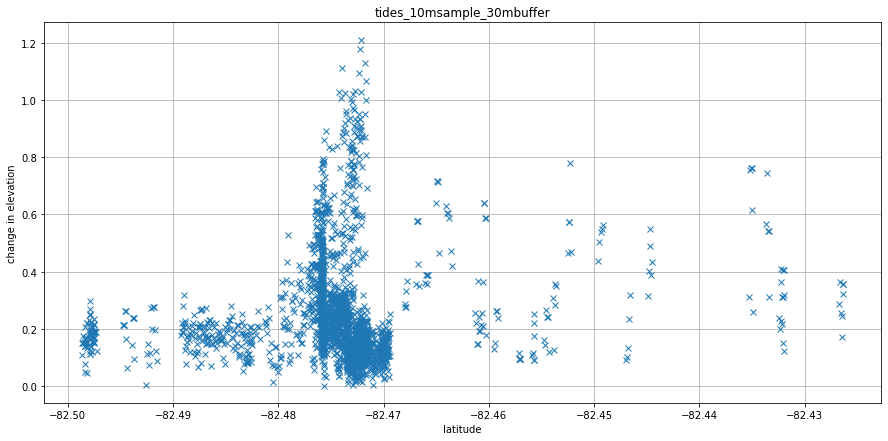

In [7]:
plot_tides(3,paths)

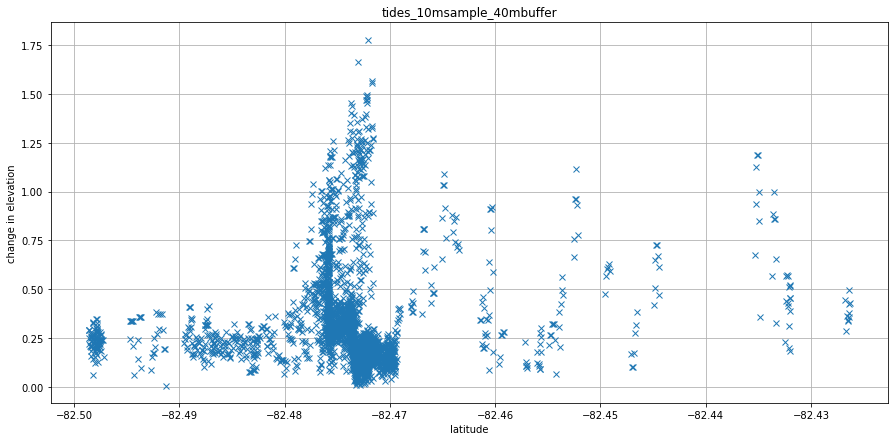

In [8]:
plot_tides(4,paths)

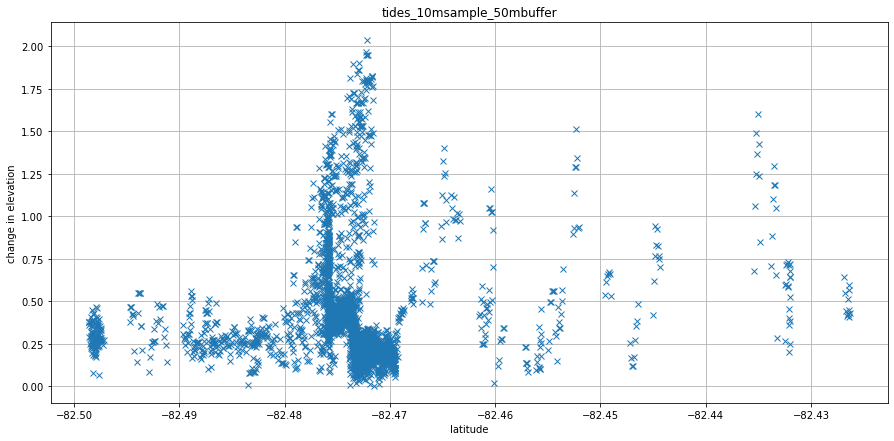

In [9]:
plot_tides(5,paths)

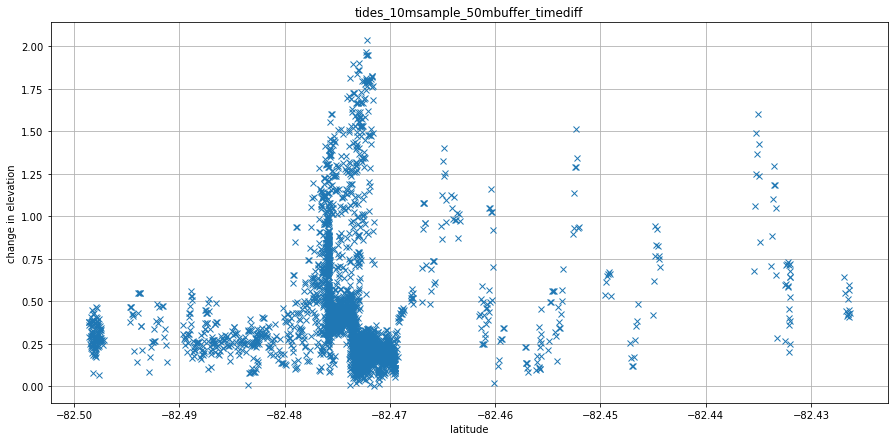

In [10]:
plot_tides(6,paths)

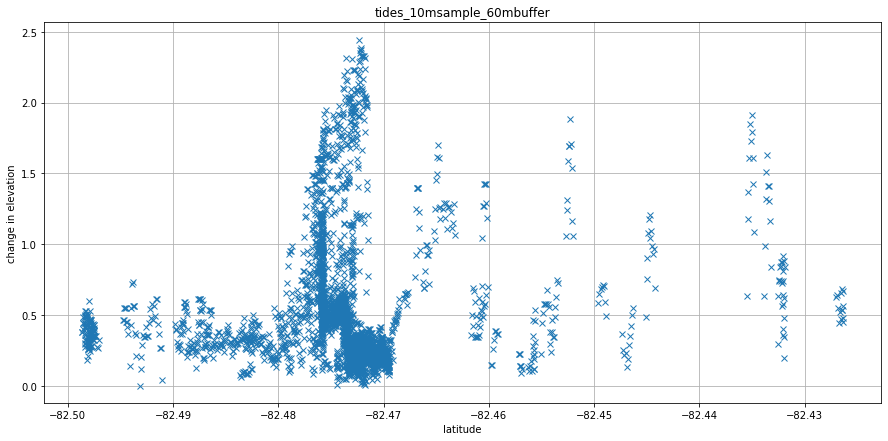

In [11]:
plot_tides(7,paths)

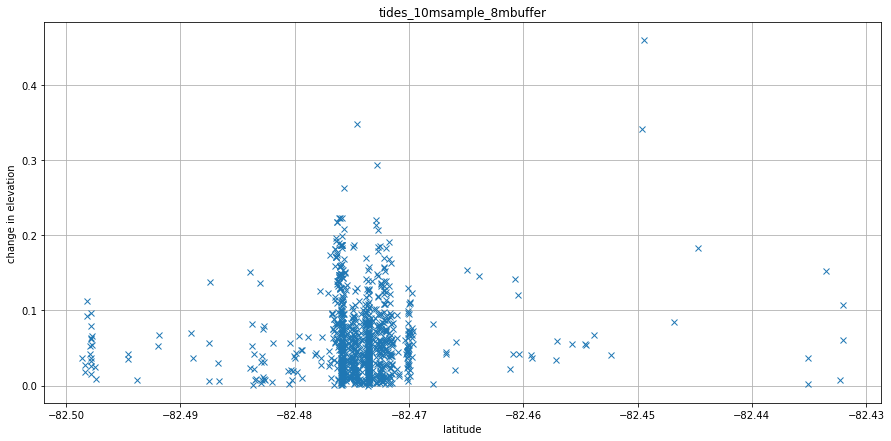

In [12]:
plot_tides(8,paths)

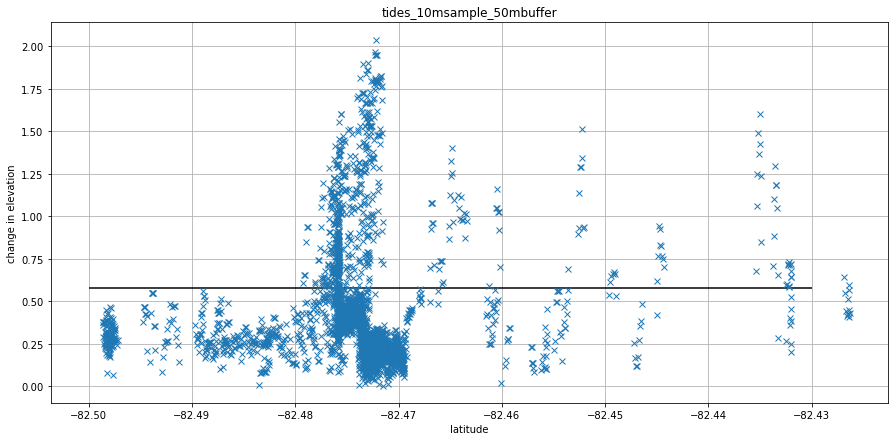

In [13]:
plot_tides(5,paths)
plt.hlines(0.58,-82.5,-82.43)

# Draw a grounding line

drawing a grounding line, it will help to have more points. So ill use the 10m sample, 50m buffer

The cut off line for what represents tide is 0.58m, so $0.58/50  = 0.0116$ the gradient. If we have a slope this big, it will be picked up as tide.

NB the index on `tides_10msample_50mbuffer.pkl` is what i have called index1 in the past, ie it can be used to reference `radar_gnss_track_KIS2.shp`

In [14]:
df = pd.read_pickle('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_50mbuffer.pkl')
tides_df = gpd.GeoDataFrame(df,geometry=df.geometry)

gdf = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/radar_gnss_track_KIS2.shp')

In [15]:
tides_df['grounded'] = tides_df.tide < 0.58

In [16]:
indicies_grounded = ( [val for sublist in tides_df[tides_df.grounded].intx_points.to_list() for val in sublist]
                     + tides_df[tides_df.grounded].index.to_list() )

indicies_float = ( [val for sublist in tides_df[~tides_df.grounded].intx_points.to_list() for val in sublist]
                     + tides_df[~tides_df.grounded].index.to_list() )

In [17]:
floating_polygon = MultiPoint(gdf.iloc[indicies_float].geometry.to_list()).convex_hull

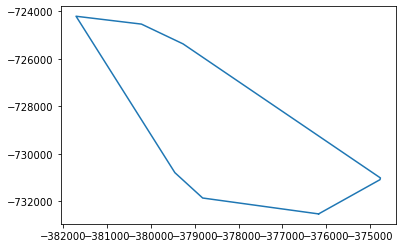

In [18]:
plt.plot(floating_polygon.exterior.xy[0],floating_polygon.exterior.xy[1])

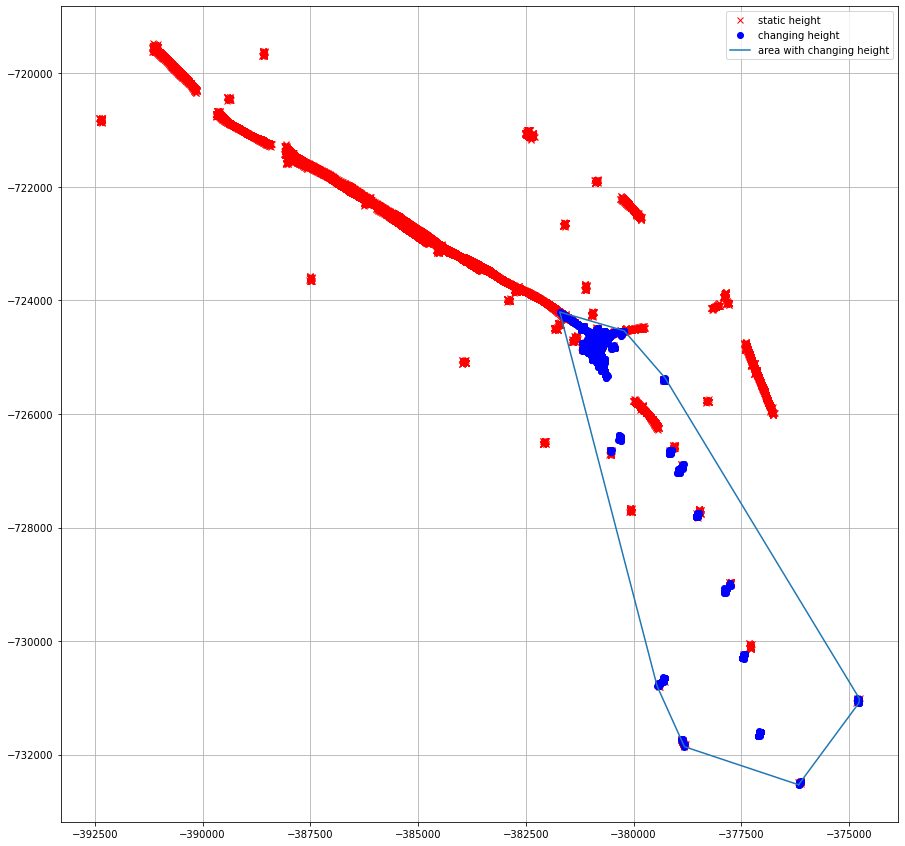

In [19]:
plt.figure(figsize=(15,15))
plt.plot(gdf.iloc[indicies_grounded].geometry.x,gdf.iloc[indicies_grounded].geometry.y,'rx')
plt.plot(gdf.iloc[indicies_float].geometry.x,gdf.iloc[indicies_float].geometry.y,'bo')
plt.plot(floating_polygon.exterior.xy[0],floating_polygon.exterior.xy[1])
plt.legend(['static height','changing height','area with changing height'])
plt.grid()

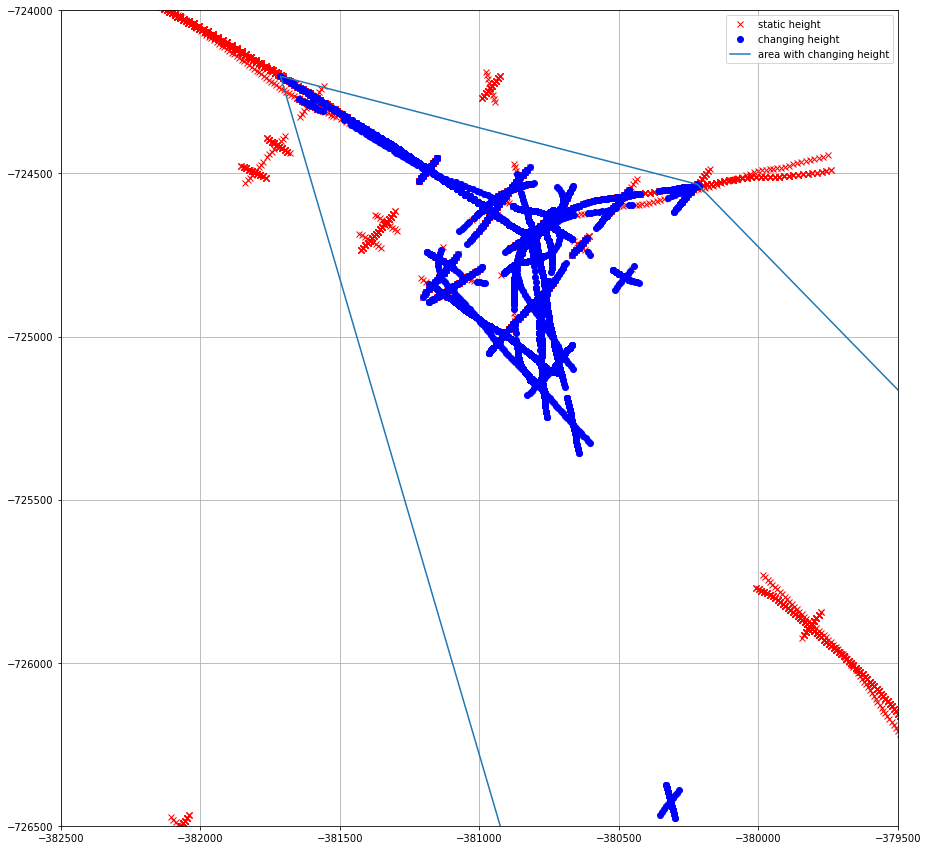

In [20]:
plt.figure(figsize=(15,15))
plt.plot(gdf.iloc[indicies_grounded].geometry.x,gdf.iloc[indicies_grounded].geometry.y,'rx')
plt.plot(gdf.iloc[indicies_float].geometry.x,gdf.iloc[indicies_float].geometry.y,'bo')
plt.plot(floating_polygon.exterior.xy[0],floating_polygon.exterior.xy[1])
plt.legend(['static height','changing height','area with changing height'])
plt.xlim([-382500,-379500])
plt.ylim([ -726500,-724000])
plt.grid()

In [21]:
aa = pd.DataFrame({'geometry': [floating_polygon]})
gpd.GeoDataFrame(aa,geometry=aa.geometry).to_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/polygon_float.shp')

# Plot floating area vs rema difference

rema difference notebook are at radarlines_over_rema_plots.ipynb

In [22]:
import rasterio as rio
df_rema = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/REMA_Strip_Index_Rel1.shp')
kis2 = [-380737.537026,-724683.311299]

In [23]:
def plot_REMA_diff(nid1,nid2,line_name,df=df,v=[0,10]):
    
    path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
    image = rio.open(path)
    extent = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    gdf = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")
    f = df.loc[nid1].acquisitio
    t =df.loc[nid2].acquisitio
    xmin,xmax = [gdf.geometry.x.to_numpy().min(),gdf.geometry.x.to_numpy().max()]
    ymin,ymax = [gdf.geometry.y.to_numpy().min(),gdf.geometry.y.to_numpy().max()]
    plt.figure(figsize=(15,14))
    plt.imshow(image.read(1),extent=extent, vmin=v[0],vmax=v[1])
    plt.xlim([xmin-1000, xmax])
    plt.ylim([ymin-1000,ymax])
    cb = plt.colorbar()
    plt.plot(gdf.geometry.x,gdf.geometry.y,'y')
    plt.plot(kis2[0],kis2[1],'y^')
    plt.title(f'REMA elevation change from {f} till {t}')
    cb.set_label('elevation change, m')
    

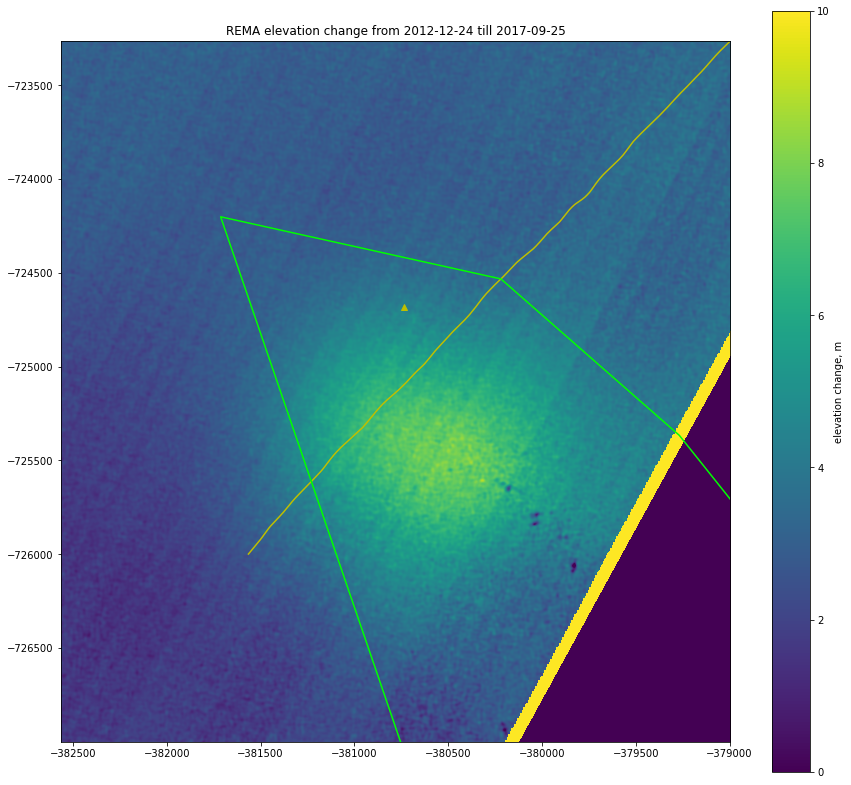

In [24]:

plot_REMA_diff(159202,145074,'line7',df=df_rema)
plt.plot(floating_polygon.exterior.xy[0],floating_polygon.exterior.xy[1],color='lime')


# Plot with time difference

Plot which part of the tidal cycle points were taken at to get max tide change

In [25]:
repeated = pd.read_pickle('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/tides_10msample_50mbuffer_timediff.pkl')
float_poly = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/INTERSECTIONS/polygon_float.shp')

In [26]:
# 0, 10 is same place in the tidal cycle, 5 is halfway through ie most different
repeated['tide_at']=(repeated.time_diff*10).round(0).astype(int).astype(str)
grounded = repeated[repeated.tide < 0.58]
floating = repeated[repeated.tide > 0.58]

In [27]:
float_poly.iloc[0].geometry.exterior.coords.xy[0]

array('d', [-376171.35784186743, -378820.04189492896, -379454.4090882243, -381712.6822130751, -380218.7012464464, -379267.920631479, -374759.12300265447, -374768.814973413, -376171.35784186743])

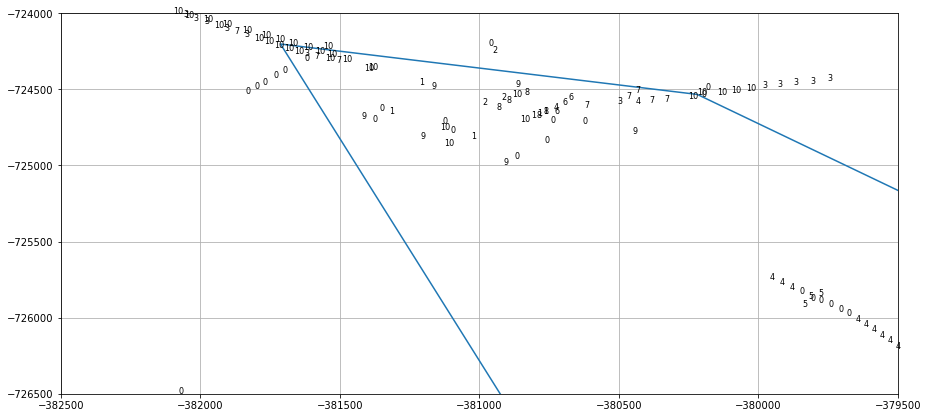

In [28]:
plt.figure(figsize=(15,7))
plt.plot(float_poly.iloc[0].geometry.exterior.coords.xy[0],float_poly.iloc[0].geometry.exterior.coords.xy[1])
plt.xlim([-382500,-379500])
plt.ylim([ -726500,-724000])
plt.grid()

for i,row in grounded.iloc[::4].iterrows():
    if  (-382500 < row.geometry.x < -379500) & (-726500 < row.geometry.y < -724000):
        plt.text(row.geometry.x,row.geometry.y,row.tide_at,fontsize=8)
    

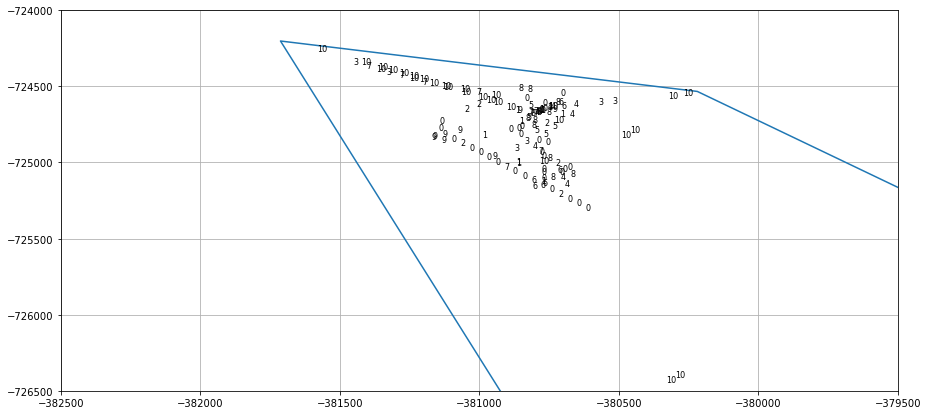

In [29]:
plt.figure(figsize=(15,7))
plt.plot(float_poly.iloc[0].geometry.exterior.coords.xy[0],float_poly.iloc[0].geometry.exterior.coords.xy[1])
plt.xlim([-382500,-379500])
plt.ylim([ -726500,-724000])
plt.grid()

for i,row in floating.iloc[::4].iterrows():
    if  (-382500 < row.geometry.x < -379500) & (-726500 < row.geometry.y < -724000):
        plt.text(row.geometry.x,row.geometry.y,row.tide_at,fontsize=8)

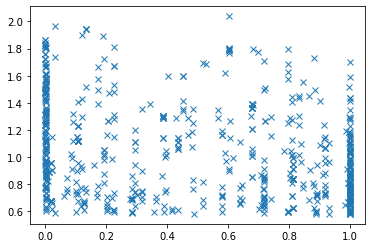

In [30]:
plt.plot(floating.time_diff,floating.tide,'x')

The above shows there is no correlation between height change and tide period time, and therefore this analysis is flawed.
Tide period of 1/2 a period should have larger height change!

I think that the slopes are being picked up as changing tide!